In [1]:
#Author     : Fan Li
#Update Date: 01/10/2022
#Version    : 3.0

#Intrusion Detection System Using Machine Learning (CatBoost)

#Original Data (cic ids 2017)

#Adaptive Synthenic Minority Over-sampling Technique (ADASYN)

#hardware
#12vCPUs | 48GiB | c7.3xlarge.4

#System
#Ubuntu 20.04 server 64bit

In [2]:
#1. Loading Module
#basic
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'
import gc    #memory manage

import math
import numpy as np
import pandas as pd

#draw figure
import seaborn as sns
import matplotlib.pyplot as plt

#preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from collections import Counter

#Feature Selection

from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

#model
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.neighbors import KNeighborsClassifier

#metrics

from sklearn import model_selection,feature_selection,utils,ensemble,metrics
from catboost import CatBoostClassifier

#over-sampling and under sampling
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE,ADASYN

#time
from time import time
import datetime

In [3]:
#2. Reading Dataset
base_path="../../data/"
# Monday benign
f1_path=base_path+"Monday-WorkingHours.pcap_ISCX.csv"
f1=pd.read_csv(f1_path)
#Tuesday benign
f2_path=base_path+"Tuesday-WorkingHours.pcap_ISCX.csv"
f2=pd.read_csv(f2_path)
#Wed benign
f3_path=base_path+"Wednesday-workingHours.pcap_ISCX.csv"
f3=pd.read_csv(f3_path)
#Thur WebAttack
f4_path1=base_path+"Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv"
f41=pd.read_csv(f4_path1)
f4_path2=base_path+"Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv"
f42=pd.read_csv(f4_path2)
#Fri Benign DDos PortScan
f5_path1=base_path+"Friday-WorkingHours-Morning.pcap_ISCX.csv"
f51=pd.read_csv(f5_path1)

f5_path2=base_path+"Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv"
f52=pd.read_csv(f5_path2)

f5_path3=base_path+"Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv"
f53=pd.read_csv(f5_path3)

In [4]:
data=pd.concat((f1,f2,f3,f41,f42,f51,f52,f53))
data.reset_index(inplace=True,drop=True) # duplicate index exist, reset index
data.shape

(2830743, 79)

In [5]:
data

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,49188,4,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,49486,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2830738,61374,61,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830739,61378,72,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830740,61375,75,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830741,61323,48,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [6]:
# too few samples in some subclasses of Web Attack, and they are combined into one class.
#Tuesday Brute Force
data[' Label'].replace("FTP-Patator","BruteForce",inplace=True,regex=True)
data[' Label'].replace("SSH-Patator","BruteForce",inplace=True,regex=True)
#Thursday Web Attack
data[' Label'].replace("Web Attack .*","Web Attack",inplace=True,regex=True)
#DoS 
data[' Label'].replace("DoS .*","DoS",inplace=True,regex=True)
data[' Label'].replace("DDoS","DoS",inplace=True,regex=True)

In [7]:
target_count_new=data[' Label'].value_counts(0)
target_count_new

BENIGN          2273097
DoS              380688
PortScan         158930
BruteForce        13835
Web Attack         2180
Bot                1966
Infiltration         36
Heartbleed           11
Name:  Label, dtype: int64

In [8]:
labels_new,values_new=zip(*sorted(target_count_new.items()))

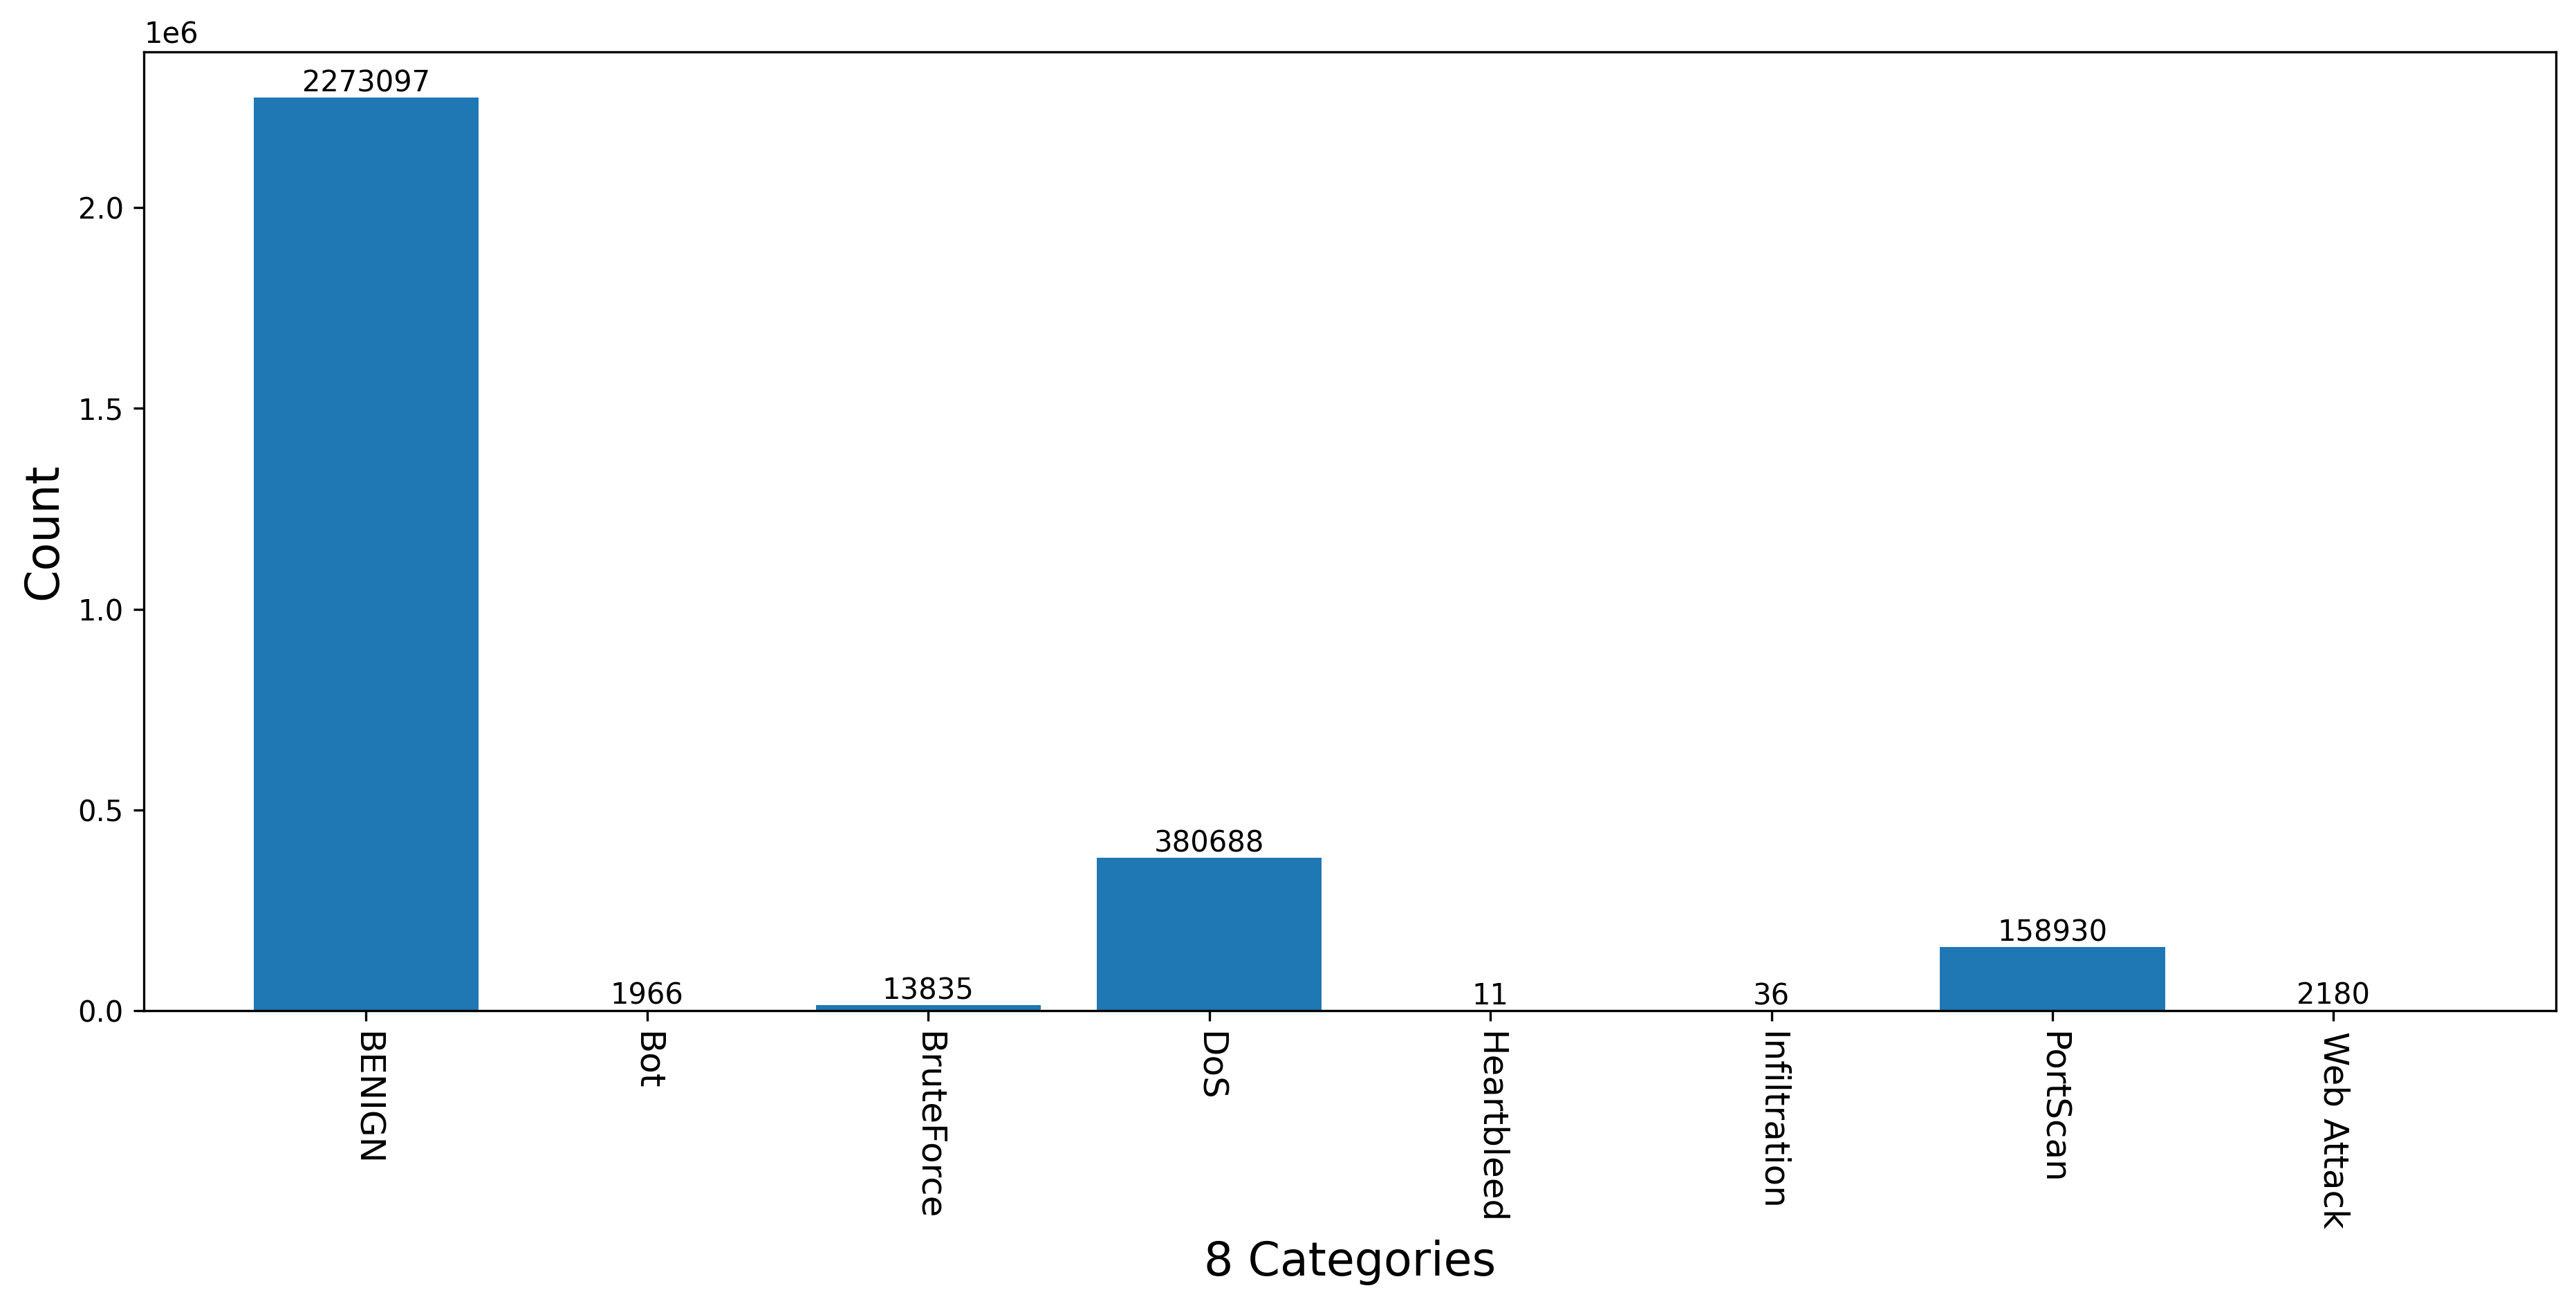

In [9]:
plt.figure(dpi=300,figsize=(15,6))
plt.bar(labels_new,values_new)
for x_new,y_new in zip(labels_new,values_new):
    plt.text(x_new,y_new,y_new,ha="center",va="bottom")
plt.xticks(fontsize=12,rotation=-90)
plt.xlabel("8 Categories",fontsize=16)
plt.ylabel("Count",fontsize=16)
plt.show()

In [10]:
#3. Preprocessing
#3.1 remove useless data
#remove duplicate row
data=data.drop_duplicates()
#remove rows with null value and infinite value
data=data.replace(np.inf,np.nan)
data=data.dropna()

In [11]:
data[' Label'].value_counts()

BENIGN          2072476
DoS              321759
PortScan          90694
BruteForce         9150
Web Attack         2143
Bot                1948
Infiltration         36
Heartbleed           11
Name:  Label, dtype: int64

In [12]:
X=data.iloc[:,:-1]
y=data.iloc[:,-1]
print(Counter(y))

Counter({'BENIGN': 2072476, 'DoS': 321759, 'PortScan': 90694, 'BruteForce': 9150, 'Web Attack': 2143, 'Bot': 1948, 'Infiltration': 36, 'Heartbleed': 11})


In [13]:
#Label Encoding
le=LabelEncoder()
le=le.fit(y)
le.classes_
y=le.transform(y)
print(Counter(y))

Counter({0: 2072476, 3: 321759, 6: 90694, 2: 9150, 7: 2143, 1: 1948, 5: 36, 4: 11})


In [14]:
#Ram Clean
del data
gc.collect()

3692

In [15]:
#3.2 Splitting data
X_train,X_test,y_train,y_test=model_selection.train_test_split(X,y,test_size=0.33,random_state=123456)

In [16]:
print(Counter(y_train))

Counter({0: 1388615, 3: 215467, 6: 60860, 2: 6100, 7: 1440, 1: 1293, 5: 20, 4: 10})


In [17]:
#3.3 SMOTE
time0=time()
AdaSYN=ADASYN(random_state=42,n_jobs=-1)
X_train,y_train=AdaSYN.fit_resample(X_train,y_train)

In [18]:
print("Time of ADASYN : {:.3f} s".format(time()-time0))

Time of ADASYN : 564.126 s


In [19]:
print(Counter(y_train))

Counter({3: 1389254, 2: 1388653, 0: 1388615, 4: 1388615, 5: 1388613, 7: 1388608, 1: 1388420, 6: 1387215})


In [20]:
#4. Training
clf=CatBoostClassifier(random_state=12345)

In [21]:
time1=time()
clf.fit(X_train,y_train)
print("Time of Training : {:.3f} s".format(time()-time1))

Learning rate set to 0.127248
0:	learn: 1.4173178	total: 4.79s	remaining: 1h 19m 43s
1:	learn: 1.1418429	total: 9.31s	remaining: 1h 17m 27s
2:	learn: 0.9578643	total: 13.8s	remaining: 1h 16m 10s
3:	learn: 0.8262396	total: 18.2s	remaining: 1h 15m 43s
4:	learn: 0.7237479	total: 22.5s	remaining: 1h 14m 36s
5:	learn: 0.6366064	total: 26.6s	remaining: 1h 13m 23s
6:	learn: 0.5693132	total: 30.3s	remaining: 1h 11m 44s
7:	learn: 0.5075204	total: 34.5s	remaining: 1h 11m 16s
8:	learn: 0.4572504	total: 38.6s	remaining: 1h 10m 53s
9:	learn: 0.4148922	total: 42.8s	remaining: 1h 10m 35s
10:	learn: 0.3749211	total: 47.6s	remaining: 1h 11m 17s
11:	learn: 0.3427545	total: 51.5s	remaining: 1h 10m 40s
12:	learn: 0.3136248	total: 56.2s	remaining: 1h 11m 6s
13:	learn: 0.2878113	total: 1m	remaining: 1h 10m 59s
14:	learn: 0.2590467	total: 1m 5s	remaining: 1h 11m 44s
15:	learn: 0.2374790	total: 1m 10s	remaining: 1h 11m 45s
16:	learn: 0.2188211	total: 1m 14s	remaining: 1h 11m 45s
17:	learn: 0.2020112	total: 1m

150:	learn: 0.0120920	total: 9m 22s	remaining: 52m 44s
151:	learn: 0.0119984	total: 9m 26s	remaining: 52m 38s
152:	learn: 0.0119190	total: 9m 28s	remaining: 52m 29s
153:	learn: 0.0118251	total: 9m 32s	remaining: 52m 27s
154:	learn: 0.0117255	total: 9m 37s	remaining: 52m 28s
155:	learn: 0.0116514	total: 9m 41s	remaining: 52m 23s
156:	learn: 0.0115798	total: 9m 44s	remaining: 52m 17s
157:	learn: 0.0115183	total: 9m 47s	remaining: 52m 11s
158:	learn: 0.0110071	total: 9m 52s	remaining: 52m 14s
159:	learn: 0.0108987	total: 9m 56s	remaining: 52m 13s
160:	learn: 0.0108162	total: 10m	remaining: 52m 8s
161:	learn: 0.0107190	total: 10m 4s	remaining: 52m 5s
162:	learn: 0.0106288	total: 10m 8s	remaining: 52m 5s
163:	learn: 0.0105594	total: 10m 12s	remaining: 52m
164:	learn: 0.0104354	total: 10m 16s	remaining: 51m 58s
165:	learn: 0.0103659	total: 10m 19s	remaining: 51m 52s
166:	learn: 0.0103202	total: 10m 23s	remaining: 51m 51s
167:	learn: 0.0102683	total: 10m 27s	remaining: 51m 47s
168:	learn: 0.0

298:	learn: 0.0055994	total: 18m 39s	remaining: 43m 43s
299:	learn: 0.0055829	total: 18m 43s	remaining: 43m 41s
300:	learn: 0.0055475	total: 18m 46s	remaining: 43m 36s
301:	learn: 0.0055369	total: 18m 49s	remaining: 43m 30s
302:	learn: 0.0055169	total: 18m 55s	remaining: 43m 30s
303:	learn: 0.0054929	total: 18m 59s	remaining: 43m 28s
304:	learn: 0.0054783	total: 19m 3s	remaining: 43m 24s
305:	learn: 0.0054613	total: 19m 7s	remaining: 43m 22s
306:	learn: 0.0054373	total: 19m 10s	remaining: 43m 17s
307:	learn: 0.0054184	total: 19m 15s	remaining: 43m 16s
308:	learn: 0.0054062	total: 19m 19s	remaining: 43m 12s
309:	learn: 0.0053888	total: 19m 23s	remaining: 43m 8s
310:	learn: 0.0053806	total: 19m 27s	remaining: 43m 5s
311:	learn: 0.0053699	total: 19m 30s	remaining: 43m 1s
312:	learn: 0.0053510	total: 19m 34s	remaining: 42m 58s
313:	learn: 0.0053321	total: 19m 37s	remaining: 42m 53s
314:	learn: 0.0052731	total: 19m 41s	remaining: 42m 49s
315:	learn: 0.0052575	total: 19m 45s	remaining: 42m 4

446:	learn: 0.0039069	total: 27m 42s	remaining: 34m 16s
447:	learn: 0.0039054	total: 27m 45s	remaining: 34m 12s
448:	learn: 0.0038975	total: 27m 49s	remaining: 34m 8s
449:	learn: 0.0038901	total: 27m 53s	remaining: 34m 5s
450:	learn: 0.0038856	total: 27m 56s	remaining: 34m
451:	learn: 0.0038800	total: 28m	remaining: 33m 57s
452:	learn: 0.0038664	total: 28m 4s	remaining: 33m 54s
453:	learn: 0.0038626	total: 28m 8s	remaining: 33m 50s
454:	learn: 0.0038577	total: 28m 12s	remaining: 33m 47s
455:	learn: 0.0038568	total: 28m 15s	remaining: 33m 42s
456:	learn: 0.0038503	total: 28m 18s	remaining: 33m 37s
457:	learn: 0.0038419	total: 28m 22s	remaining: 33m 34s
458:	learn: 0.0038356	total: 28m 27s	remaining: 33m 32s
459:	learn: 0.0038328	total: 28m 30s	remaining: 33m 27s
460:	learn: 0.0038173	total: 28m 33s	remaining: 33m 23s
461:	learn: 0.0038136	total: 28m 37s	remaining: 33m 20s
462:	learn: 0.0038106	total: 28m 42s	remaining: 33m 17s
463:	learn: 0.0038089	total: 28m 45s	remaining: 33m 13s
464:

594:	learn: 0.0032126	total: 36m 34s	remaining: 24m 53s
595:	learn: 0.0032060	total: 36m 38s	remaining: 24m 50s
596:	learn: 0.0032033	total: 36m 41s	remaining: 24m 46s
597:	learn: 0.0032015	total: 36m 45s	remaining: 24m 42s
598:	learn: 0.0032006	total: 36m 48s	remaining: 24m 38s
599:	learn: 0.0031956	total: 36m 53s	remaining: 24m 35s
600:	learn: 0.0031929	total: 36m 57s	remaining: 24m 32s
601:	learn: 0.0031871	total: 37m 1s	remaining: 24m 28s
602:	learn: 0.0031827	total: 37m 5s	remaining: 24m 25s
603:	learn: 0.0031815	total: 37m 8s	remaining: 24m 21s
604:	learn: 0.0031755	total: 37m 11s	remaining: 24m 17s
605:	learn: 0.0031734	total: 37m 15s	remaining: 24m 13s
606:	learn: 0.0031681	total: 37m 19s	remaining: 24m 10s
607:	learn: 0.0031655	total: 37m 22s	remaining: 24m 5s
608:	learn: 0.0031626	total: 37m 26s	remaining: 24m 2s
609:	learn: 0.0031603	total: 37m 31s	remaining: 23m 59s
610:	learn: 0.0031531	total: 37m 34s	remaining: 23m 55s
611:	learn: 0.0031518	total: 37m 37s	remaining: 23m 5

742:	learn: 0.0027873	total: 45m 39s	remaining: 15m 47s
743:	learn: 0.0027854	total: 45m 43s	remaining: 15m 43s
744:	learn: 0.0027840	total: 45m 47s	remaining: 15m 40s
745:	learn: 0.0027813	total: 45m 51s	remaining: 15m 36s
746:	learn: 0.0027737	total: 45m 56s	remaining: 15m 33s
747:	learn: 0.0027700	total: 45m 59s	remaining: 15m 29s
748:	learn: 0.0027676	total: 46m 3s	remaining: 15m 25s
749:	learn: 0.0027664	total: 46m 6s	remaining: 15m 22s
750:	learn: 0.0027650	total: 46m 10s	remaining: 15m 18s
751:	learn: 0.0027627	total: 46m 13s	remaining: 15m 14s
752:	learn: 0.0027604	total: 46m 17s	remaining: 15m 10s
753:	learn: 0.0027594	total: 46m 20s	remaining: 15m 7s
754:	learn: 0.0027577	total: 46m 23s	remaining: 15m 3s
755:	learn: 0.0027573	total: 46m 26s	remaining: 14m 59s
756:	learn: 0.0027560	total: 46m 30s	remaining: 14m 55s
757:	learn: 0.0027545	total: 46m 34s	remaining: 14m 52s
758:	learn: 0.0027542	total: 46m 36s	remaining: 14m 48s
759:	learn: 0.0027529	total: 46m 40s	remaining: 14m 

891:	learn: 0.0025230	total: 54m 29s	remaining: 6m 35s
892:	learn: 0.0025209	total: 54m 32s	remaining: 6m 32s
893:	learn: 0.0025199	total: 54m 37s	remaining: 6m 28s
894:	learn: 0.0025191	total: 54m 40s	remaining: 6m 24s
895:	learn: 0.0025155	total: 54m 44s	remaining: 6m 21s
896:	learn: 0.0025150	total: 54m 47s	remaining: 6m 17s
897:	learn: 0.0025140	total: 54m 51s	remaining: 6m 13s
898:	learn: 0.0025111	total: 54m 55s	remaining: 6m 10s
899:	learn: 0.0025095	total: 54m 58s	remaining: 6m 6s
900:	learn: 0.0025090	total: 55m 2s	remaining: 6m 2s
901:	learn: 0.0025083	total: 55m 6s	remaining: 5m 59s
902:	learn: 0.0025077	total: 55m 10s	remaining: 5m 55s
903:	learn: 0.0025051	total: 55m 14s	remaining: 5m 51s
904:	learn: 0.0025026	total: 55m 17s	remaining: 5m 48s
905:	learn: 0.0025022	total: 55m 21s	remaining: 5m 44s
906:	learn: 0.0025015	total: 55m 26s	remaining: 5m 41s
907:	learn: 0.0025003	total: 55m 28s	remaining: 5m 37s
908:	learn: 0.0024979	total: 55m 33s	remaining: 5m 33s
909:	learn: 0.

In [22]:
y_pred_train=clf.predict(X_train)
y_pred_test=clf.predict(X_test)

In [23]:
y_train_en=OneHotEncoder().fit_transform(pd.DataFrame(y_train)).toarray()

In [24]:
y_pred_train_en=OneHotEncoder().fit_transform(pd.DataFrame(y_pred_train)).toarray()

In [25]:
y_train_en,y_pred_train_en

(array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]]),
 array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]]))

In [26]:
y_test_en=OneHotEncoder().fit_transform(pd.DataFrame(y_test)).toarray()

In [27]:
y_pred_test_en=OneHotEncoder().fit_transform(pd.DataFrame(y_pred_test)).toarray()

In [28]:
y_test_en,y_pred_test_en

(array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]]),
 array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]]))

In [29]:
#5. Result 
#5.1 Train
print("==Train==")
result=metrics.confusion_matrix(y_train,y_pred_train)
report=metrics.classification_report(y_train,y_pred_train,zero_division=1)

print(result)
print(report)

print("Accuracy Score = ",metrics.balanced_accuracy_score(y_train,y_pred_train))
print("Precison       = ",metrics.precision_score(y_train,y_pred_train,average='macro'))
print("Recall         = ",metrics.recall_score(y_train,y_pred_train,average='macro'))
print("F1_score       = ",metrics.f1_score(y_train,y_pred_train,average='macro'))
print("Auc score      = ",metrics.roc_auc_score(y_train_en,y_pred_train_en,average='macro'))

==Train==
[[1385559    1386       4     932       0       0     631     103]
 [     21 1388399       0       0       0       0       0       0]
 [      0       0 1388653       0       0       0       0       0]
 [     37       0       0 1387652       0       0    1199     366]
 [      0       0       0       0 1388615       0       0       0]
 [      0       0       0       0       0 1388613       0       0]
 [      1       0       0     321       0       0 1386288     605]
 [      2       0       0      63       0       0      21 1388522]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1388615
           1       1.00      1.00      1.00   1388420
           2       1.00      1.00      1.00   1388653
           3       1.00      1.00      1.00   1389254
           4       1.00      1.00      1.00   1388615
           5       1.00      1.00      1.00   1388613
           6       1.00      1.00      1.00   1387215
           7       1

In [30]:
precision,recall,fscore,none= metrics.precision_recall_fscore_support(y_train, y_pred_train, average='weighted') 
print("Accuracy Score     : "+(str(metrics.accuracy_score(y_train,y_pred_train))))
print('Weighted Precision : '+(str(precision)))
print('Weighted Recall    : '+(str(recall)))
print('Weighted F1-score  : '+(str(fscore)))

Accuracy Score     : 0.9994875761985086
Weighted Precision : 0.9994878421491981
Weighted Recall    : 0.9994875761985086
Weighted F1-score  : 0.9994875025252203


In [31]:
#5.2 Test
print("==Test==")
result=metrics.confusion_matrix(y_test,y_pred_test)
report=metrics.classification_report(y_test,y_pred_test,zero_division=1)

print(result)
print(report)

print("Accuracy Score = ",metrics.balanced_accuracy_score(y_test,y_pred_test))
print("Precison       = ",metrics.precision_score(y_test,y_pred_test,average='macro'))
print("Recall         = ",metrics.recall_score(y_test,y_pred_test,average='macro'))
print("F1_score       = ",metrics.f1_score(y_test,y_pred_test,average='macro'))
print("Auc score      = ",metrics.roc_auc_score(y_test_en,y_pred_test_en,average='macro'))

==Test==
[[682203    778      4    460      0      2    358     56]
 [     3    652      0      0      0      0      0      0]
 [     0      0   3049      0      0      0      0      1]
 [     8      0      0 106202      0      0     79      3]
 [     0      0      0      0      1      0      0      0]
 [     2      0      0      0      0     14      0      0]
 [     3      0      0      1      0      0  29828      2]
 [     2      0      0     34      0      0     11    656]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    683861
           1       0.46      1.00      0.63       655
           2       1.00      1.00      1.00      3050
           3       1.00      1.00      1.00    106292
           4       1.00      1.00      1.00         1
           5       0.88      0.88      0.88        16
           6       0.99      1.00      0.99     29834
           7       0.91      0.93      0.92       703

    accuracy                  

In [32]:
tprecision,trecall,tfscore,none= metrics.precision_recall_fscore_support(y_test, y_pred_test, average='weighted')
print("Accuracy Score     : "+(str(metrics.accuracy_score(y_test,y_pred_test))))
print('Weighted Precision : '+(str(tprecision)))
print('Weighted Recall    : '+(str(trecall)))
print('Weighted F1-score  : '+(str(tfscore)))

Accuracy Score     : 0.9978081347675677
Weighted Precision : 0.9983313180329761
Weighted Recall    : 0.9978081347675677
Weighted F1-score  : 0.997986377856676


### Random Forest With Original Data   
Accuracy Score =  0.9103102912538195   
Precison       =  0.9684073872067926   
Recall         =  0.9103102912538195   
F1_score       =  0.9340837954082126   
Auc score      =  0.9548073632993797   

### Weight Metrics   
Accuracy Score     : 0.9985189444112895   
Weighted Precision : 0.99850615428196   
Weighted Recall    : 0.9985189444112895   
Weighted F1-score  : 0.9985091535241425   

### Random Forest With SMOTE   
Accuracy Score =  0.9563704217494868   
Precison       =  0.9549066052533266   
Recall         =  0.9563704217494868   
F1_score       =  0.9506837090876916   
Auc score      =  0.9779754647818648

### Weight Metrics After SMOTE   
Accuracy Score     : 0.9985759547410761   
Weighted Precision : 0.998684046700059   
Weighted Recall    : 0.9985759547410761   
Weighted F1-score  : 0.9986116272645491   

### CatBoost With Original Data  
Accuracy Score =  0.9336474366337519  
Precison       =  0.9837375280939686  
Recall         =  0.9336474366337519  
F1_score       =  0.9555094493490739  
Auc score      =  0.9666818721003482  

### Weighted Metrics
Accuracy Score : 0.9990635750086122
Weighted Precision : 0.9990537650619968
Weighted Recall : 0.9990635750086122
Weighted F1-score : 0.9990511323114969

### CatBoost With SMOTE  
Accuracy Score =  0.9834205843500247  
Precison       =  0.911111973463963  
Recall         =  0.9834205843500247  
F1_score       =  0.9366340995285412  
Auc score      =  0.9916013072331797  

In [33]:
###  Weighted Metrics
Accuracy Score     : 0.9984316094379995
Weighted Precision : 0.9988458646460229
Weighted Recall    : 0.9984316094379995
Weighted F1-score  : 0.9985691110364114

SyntaxError: invalid syntax (2747440689.py, line 2)